In [1]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
import logging.config
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "6"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
sys.path = sys.path[1:]
sys.path.append(os.path.abspath(os.pardir))
#sys.path.append(os.path.join(os.path.abspath(os.pardir), 'odometry'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tfoptflow/tfoptflow'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tf_models/research/struct2depth'))

## Data

In [3]:
from odometry.preprocessing.data_parser import (KITTIParser,
                                                TUMParser,
                                                RetailBotParser,
                                                DISCOMANParser)

### TUM

In [4]:
sequence_directory = 'tum'
directory = '/Vol1/dbstore/datasets/tum_rgbd_flow/data/rgbd_dataset_freiburg2_coke'
height, width = 480, 640
tum_parser = TUMParser(sequence_directory, directory=directory)

### RetailBot

In [5]:
sequence_directory = 'retailbot'
directory = '/dbstore/datasets/retail_bot/meetingroom_04_rgbd_ir_imu_pose'
height, width = 480, 640
retailbot_parser = RetailBotParser(sequence_directory, directory=directory)

### KITTI

In [6]:
sequence_directory = 'kitti'
seq_id = '01'
height, width = 94, 300
kitti_parser = KITTIParser(sequence_directory, seq_id=seq_id)

### DISCOMAN

In [7]:
sequence_directory = 'discoman'
json_path = '/dbstore/datasets/renderbox/iros2019/dset/output/deprecated/000001/0_traj.json'
height, width = 120, 160
discoman_parser = DISCOMANParser(sequence_directory, json_path=json_path)

In [8]:
#parser = tum_parser
#parser = kitti_parser
parser = discoman_parser
#parser = retailbot_parser

## Estimators

In [9]:
from odometry.preprocessing.estimators import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Quaternion2Euler

In [10]:
quaternion2euler_estimator = Quaternion2EulerEstimator(input_col=['q_w', 'q_x', 'q_y', 'q_z'],
                                                       output_col=['euler_x', 'euler_y', 'euler_z'])
quaternion2euler_estimator

Quaternion2EulerEstimator(input_col=['q_w', 'q_x', 'q_y', 'q_z'], output_col=['euler_x', 'euler_y', 'euler_z'])

### Struct2Depth

In [11]:
depth_checkpoint = os.path.abspath('../weights/model-199160')
depth_checkpoint

'/Vol0/user/a.vorontsova/odometry/weights/model-199160'

In [12]:
struct2depth_estimator = Struct2DepthEstimator(input_col='path_to_rgb',
                                               output_col='path_to_depth',
                                               directory='depth',
                                               checkpoint=depth_checkpoint, 
                                               height=height,
                                               width=width,
                                               verbose=False)
struct2depth_estimator

Instructions for updating:
Colocations handled automatically by placer.


W0614 16:13:20.742707 47842790338176 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.batch_normalization instead.


W0614 16:13:20.801069 47842790338176 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tf_models/research/struct2depth/nets.py:503: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.batch_normalization instead.
W0614 16:13:23.100697 47842790338176 util.py:204] Shape mismatch, will not restore egomotion_prediction/pose_exp_net/pose/cnv6/weights.
W0614 16:13:23.101562 47842790338176 util.py:206] The following variables in the checkpoint were not loaded:


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0614 16:13:24.046268 47842790338176 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


I0614 16:13:24.048375 47842790338176 saver.py:1270] Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


Struct2DepthEstimator(dir=depth, input_col=path_to_rgb, output_col=path_to_depth, checkpoint=/Vol0/user/a.vorontsova/odometry/weights/model-199160)

### Global2Relative

In [13]:
input_col = ['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z']
input_col.extend([col + '_next' for col in input_col])
output_col = input_col
global2relative_estimator = Global2RelativeEstimator(input_col=input_col, output_col=output_col)
global2relative_estimator

Global2RelativeEstimator(input_col=['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z', 'euler_x_next', 'euler_y_next', 'euler_z_next', 't_x_next', 't_y_next', 't_z_next'], output_col=['euler_x', 'euler_y', 'euler_z', 't_x', 't_y', 't_z', 'euler_x_next', 'euler_y_next', 'euler_z_next', 't_x_next', 't_y_next', 't_z_next'])

### PWC-Net

In [14]:
optical_flow_checkpoint = '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000'
#optical_flow_checkpoint = os.path.abspath(../weights/pwcnet.ckpt-595000')  # official weights
optical_flow_checkpoint

'/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000'

In [15]:
pwcnet_estimator = PWCNetEstimator(input_col=['path_to_rgb', 'path_to_rgb_next'],
                                   output_col='path_to_optical_flow',
                                   directory='optical_flow',
                                   checkpoint=optical_flow_checkpoint,
                                   height=height,
                                   width=width,
                                   verbose=False)
pwcnet_estimator

{'verbose': False, 'ckpt_path': '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000', 'x_dtype': tf.float32, 'x_shape': [2, None, None, 3], 'y_dtype': tf.float32, 'y_shape': [None, None, 2], 'gpu_devices': ['/device:GPU:0'], 'controller': '/device:GPU:0', 'batch_size': 1, 'use_tf_data': True, 'use_mixed_precision': False, 'pyr_lvls': 6, 'flow_pred_lvl': 2, 'search_range': 4, 'use_dense_cx': True, 'use_res_cx': True}
Instructions for updating:
Use keras.layers.conv2d instead.


W0614 16:13:47.698143 47842790338176 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1173: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d instead.


Instructions for updating:
Use keras.layers.conv2d_transpose instead.


W0614 16:13:48.887094 47842790338176 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1300: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


INFO:tensorflow:Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


I0614 16:13:52.971811 47842790338176 saver.py:1270] Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


PWCNetEstimator(dir=optical_flow, input_col=['path_to_rgb', 'path_to_rgb_next'], output_col=path_to_optical_flow, checkpoint=/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000)

In [16]:
single_frame_estimators = [quaternion2euler_estimator, struct2depth_estimator]
pair_frames_estimators = [global2relative_estimator, pwcnet_estimator]

## Prepare trajectory (ex-Builder)

In [17]:
from odometry.preprocessing.prepare_trajectory import prepare_trajectory

prepare_trajectory(sequence_directory, 
                   parser=parser, 
                   single_frame_estimators=single_frame_estimators,
                   pair_frames_estimators=pair_frames_estimators,
                   stride=1)

PWCNet: 100%|██████████| 2130/2130 [02:11<00:00, 16.26it/s]


,path_to_depth,path_to_rgb,t_x,t_y,t_z,timestamp,euler_x,euler_y,euler_z,path_to_depth_next,path_to_rgb_next,t_x_next,t_y_next,t_z_next,timestamp_next,euler_x_next,euler_y_next,euler_z_next,path_to_optical_flow
0,discoman/depth/0.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,-0.000002,-4.639008e-06,0.000244,000000,0.000028,-0.000698,4.821875e-07,discoman/depth/1.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.042820,0.831081,36.146320,000005,-0.020575,-0.589785,-0.004493,discoman/optical_flow/1.npy
1,discoman/depth/1.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,-0.000010,-1.283413e-05,0.000870,000005,0.000092,-0.002444,2.471946e-05,discoman/depth/2.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.042328,0.831089,36.147038,000010,-0.020534,-0.592228,-0.004403,discoman/optical_flow/2.npy
2,discoman/depth/2.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,-0.000038,-1.952291e-05,0.001501,000010,0.000166,-0.004189,5.193066e-05,discoman/depth/3.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.041458,0.831104,36.148262,000015,-0.020462,-0.596415,-0.004236,discoman/optical_flow/3.npy
3,discoman/depth/3.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,0.000117,-5.224603e-05,0.002114,000015,0.000337,-0.005933,-1.041026e-04,discoman/depth/4.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.040367,0.831100,36.150078,000020,-0.020137,-0.602348,-0.004215,discoman/optical_flow/4.npy
4,discoman/depth/4.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,0.000367,-9.668339e-05,0.002686,000020,0.000546,-0.007674,-3.795352e-04,discoman/depth/5.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.039146,0.831062,36.152500,000025,-0.019436,-0.610029,-0.004490,discoman/optical_flow/5.npy
5,discoman/depth/5.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,0.000202,-6.516182e-05,0.003265,000025,0.000460,-0.009421,-2.352657e-04,discoman/depth/6.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.037441,0.831068,36.155293,000030,-0.018940,-0.619453,-0.004554,discoman/optical_flow/6.npy
6,discoman/depth/6.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,0.000145,-7.142220e-05,0.003850,000030,0.000459,-0.011167,-1.948336e-04,discoman/depth/7.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.035324,0.831079,36.158512,000035,-0.018494,-0.630622,-0.004533,discoman/optical_flow/7.npy
7,discoman/depth/7.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,0.000102,-1.507633e-04,0.004821,000035,0.000854,-0.012915,1.216704e-04,discoman/depth/8.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.032562,0.831030,36.162468,000040,-0.017908,-0.643532,-0.004082,discoman/optical_flow/8.npy
8,discoman/depth/8.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,0.000454,-2.083325e-04,0.004835,000040,0.000588,-0.014653,-6.542083e-04,discoman/depth/9.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.030022,0.830919,36.166611,000045,-0.017025,-0.658195,-0.004578,discoman/optical_flow/9.npy
9,discoman/depth/9.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,0.000415,-2.107997e-04,0.005554,000045,0.000738,-0.016400,-5.111636e-04,discoman/depth/10.npy,/Vol0/user/a.vorontsova/odometry/notebooks/dis...,53.026951,0.830817,36.171261,000050,-0.016108,-0.674601,-0.004874,discoman/optical_flow/10.npy


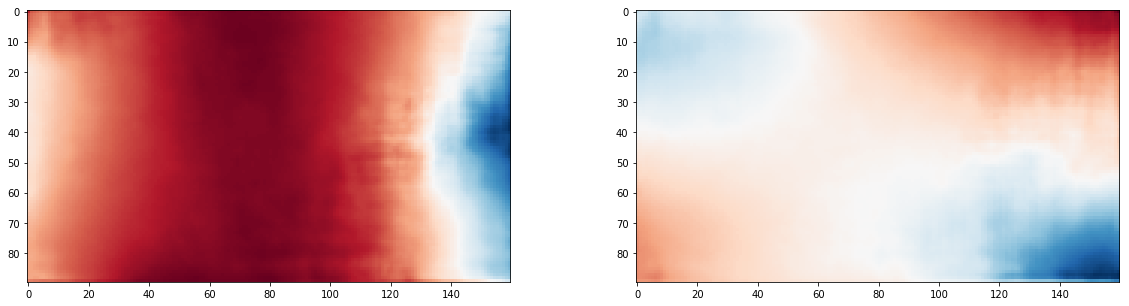

In [18]:
optical_flow_directory = os.path.join(sequence_directory, 'optical_flow')
flow = np.load(os.path.join(optical_flow_directory, os.listdir(optical_flow_directory)[0]))

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].imshow(flow[..., 0], cmap='RdBu')
ax[1].imshow(flow[..., 1], cmap='RdBu')
plt.show()

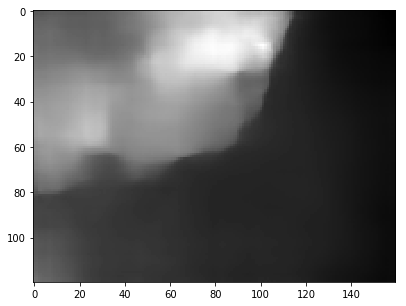

In [19]:
depth_directory = os.path.join(sequence_directory, 'depth')
depth = np.load(os.path.join(depth_directory, os.listdir(depth_directory)[0]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(depth[..., 0], cmap='gray')
plt.show()